In [33]:
#Import libraries for data cleaning and analysis  

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

#Models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


import string

import warnings
warnings.filterwarnings("ignore")

seed=293

In [2]:
#Import pre-processed DataFrame
df = pd.read_csv('final.csv')

In [4]:
def evaluate_model(model, X_test, y_test, X_train):
    """
    """

    # Get predictions
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
   
    # Print classification report
    report = classification_report(y_test, y_hat_test)
    print("Classification Report: \n")
    print(classification_report(y_test, y_hat_test))
    
    print('\n---------------\n')
    print('Training Accuracy:', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy:', accuracy_score(y_test, y_hat_test))
    print('\n---------------\n')
    

    # Build and display confusion matrix
    cmatrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.BuPu)
    plt.show()

    # Print ratio for predicted values
    correct = np.sum(y_hat_test == y_test)
    incorrect = np.sum(y_hat_test != y_test)
    print(f"Correctly classified videos from test set: {correct}, {round((correct/len(y_test)*100), 2)}%") 
    print(f"Incorrectly classified videos from test set: {incorrect}, {round((incorrect/len(y_test)*100), 2)}%")

  
    
def compare_models(X_tr, X_tst, y_tr, y_tst, models, names):
       
        """
        Inputs: 
        X_tr = your training data as pd.DataFrame
        X_tst = your testing data as pd.DataFrame
        y_tr = your training target as pd.Series
        y_tst = your testing target as pd.Series
        models = a list of model objects you want to compare
        names = a list of strings containing the names of your modelds 


        Retruns: a comparison table inclduing Accuracy on Train and Test sets for each.
       
        ------------------------
        """ 
    
    
        X_train, X_test, y_train, y_test = X_tr, X_tst, y_tr, y_tst
       
        accuracy_train_results = []
        accuracy_results = []
    
        
        for i in range(len(models)):
            clf = models[i].fit(X_train, y_train)

            print("Currently evaluating the {} model \n".format(names[i]))
            
            accuracy = accuracy_score(y_test, clf.predict(X_test))
            accuracy_results.append(accuracy)
            
            accuracy2 = accuracy_score(y_train, clf.predict(X_train))
            accuracy_train_results.append(accuracy2)
         
            
        col1 = pd.DataFrame(names)
        col2 = pd.DataFrame(accuracy_train_results)
        col3 = pd.DataFrame(accuracy_results)

        results = pd.concat([col1, col2, col3], axis='columns')
        results.columns = ['Model', "Accuracy (Train)", "Accuracy (Test)"]
        
        return results
    

In [5]:
# Split data into training and test sets
X = df['lemma_str']
y = df['ctr_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

X_train.shape, X_test.shape

((7973,), (1408,))

In [6]:
#Checking class balance in training set 
y_train.value_counts(1) * 100

Low CTR     56.641164
High CTR    30.114135
Avg CTR     13.244701
Name: ctr_range, dtype: float64

In [7]:
#Check class balance for test set
y_test.value_counts()

Low CTR     824
High CTR    418
Avg CTR     166
Name: ctr_range, dtype: int64

The strategy forward is pretty simple. Fit five vanilla models, each with both the Count Vectorizer and with TF-IDF. I'm not sure which vectorizer will yield better results, so trying both makes the most sense. 

The five models are:

- an SVM model, implemnted as an SVC classifier (supposedly better suited for smaller datasets)
- an SVM using a linear SVC 
- another linear SVM using SGD 
- Naive Bayes, implemented as MultinomialNB
- a Random Forrest 

### SVM Models

I am starting with three variations of a support-vector machine. Each model is fitted after a vectorizer in a pipeline. Then, I explore the classification report and the confusion matrix, looking for the models with the highest accuracy scores on the test set.

In [8]:
svm_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                               ("clf", SVC())
                              ])

svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('clf', SVC())])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.17      0.01      0.01       166
    High CTR       0.56      0.26      0.35       418
     Low CTR       0.64      0.94      0.76       824

    accuracy                           0.63      1408
   macro avg       0.46      0.40      0.37      1408
weighted avg       0.56      0.63      0.55      1408


---------------

Training Accuracy: 0.7337263263514361
Testing Accuracy: 0.6264204545454546

---------------



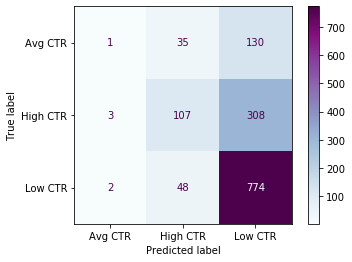

Correctly classified videos from test set: 882, 62.64%
Incorrectly classified videos from test set: 526, 37.36%


In [9]:
evaluate_model(svm_pipeline, X_test, y_test, X_train)

In [10]:
svc_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                               ("clf", LinearSVC())
                              ])

svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('clf', LinearSVC())])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.12      0.05      0.08       166
    High CTR       0.45      0.37      0.41       418
     Low CTR       0.66      0.79      0.72       824

    accuracy                           0.58      1408
   macro avg       0.41      0.40      0.40      1408
weighted avg       0.53      0.58      0.55      1408


---------------

Training Accuracy: 0.7974413646055437
Testing Accuracy: 0.5788352272727273

---------------



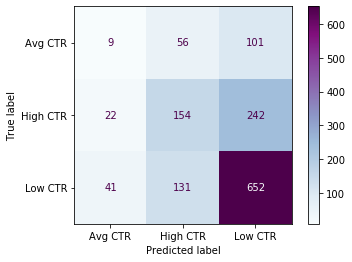

Correctly classified videos from test set: 815, 57.88%
Incorrectly classified videos from test set: 593, 42.12%


In [11]:
evaluate_model(svc_pipeline, X_test, y_test, X_train)

In [12]:
sgdc_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                               ("clf", SGDClassifier())
                              ])

sgdc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('clf', SGDClassifier())])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.14      0.04      0.06       166
    High CTR       0.46      0.34      0.39       418
     Low CTR       0.66      0.84      0.74       824

    accuracy                           0.60      1408
   macro avg       0.42      0.41      0.40      1408
weighted avg       0.54      0.60      0.56      1408


---------------

Training Accuracy: 0.7749905932522263
Testing Accuracy: 0.5965909090909091

---------------



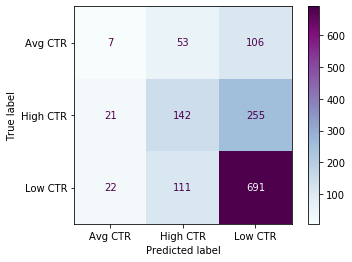

Correctly classified videos from test set: 840, 59.66%
Incorrectly classified videos from test set: 568, 40.34%


In [13]:
evaluate_model(sgdc_pipeline, X_test, y_test, X_train)

### Naive Bayes

In [14]:
nb_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                              ("nb", MultinomialNB(alpha=0.5))])

nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('nb', MultinomialNB(alpha=0.5))])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.11      0.04      0.06       166
    High CTR       0.46      0.40      0.43       418
     Low CTR       0.66      0.79      0.72       824

    accuracy                           0.59      1408
   macro avg       0.41      0.41      0.40      1408
weighted avg       0.54      0.59      0.56      1408


---------------

Training Accuracy: 0.7215602658974037
Testing Accuracy: 0.5852272727272727

---------------



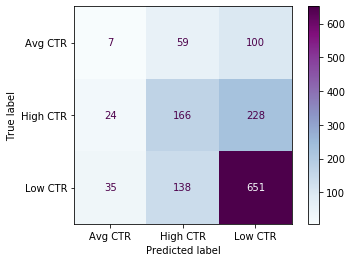

Correctly classified videos from test set: 824, 58.52%
Incorrectly classified videos from test set: 584, 41.48%


In [15]:
evaluate_model(nb_pipeline, X_test, y_test, X_train)

### Random Forest

In [16]:
rf_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                                ("rf", RandomForestClassifier())
                                      ])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('rf', RandomForestClassifier())])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.15      0.11      0.13       166
    High CTR       0.47      0.38      0.42       418
     Low CTR       0.67      0.78      0.72       824

    accuracy                           0.58      1408
   macro avg       0.43      0.42      0.42      1408
weighted avg       0.55      0.58      0.56      1408


---------------

Training Accuracy: 0.9559764204189138
Testing Accuracy: 0.5788352272727273

---------------



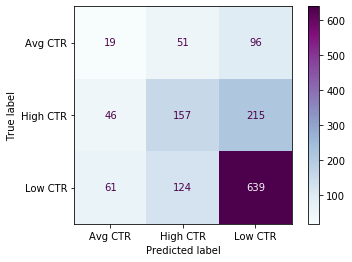

Correctly classified videos from test set: 815, 57.88%
Incorrectly classified videos from test set: 593, 42.12%


In [17]:
evaluate_model(rf_pipeline, X_test, y_test, X_train)

##### Evaluate Vanilla Models

In [18]:
#Create lists with the model objects and model names for the comparison function

vanilla_models = [svm_pipeline, svc_pipeline, sgdc_pipeline, nb_pipeline, rf_pipeline]

names = ['SVM w/ CV', "Linear SVC w/ CV", 'SGDC w/ CV', 'Multinomial Bayes w/ CV', 'Random Forrest w/ CV']

In [19]:
compare_models(X_train, X_test, y_train, y_test, vanilla_models, names)

Currently evaluating the SVM w/ CV model 

Currently evaluating the Linear SVC w/ CV model 

Currently evaluating the SGDC w/ CV model 

Currently evaluating the Multinomial Bayes w/ CV model 

Currently evaluating the Random Forrest w/ CV model 



,Model,Accuracy (Train),Accuracy (Test)
0,SVM w/ CV,0.733726,0.626420
1,Linear SVC w/ CV,0.797441,0.578835
2,SGDC w/ CV,0.775492,0.590909
3,Multinomial Bayes w/ CV,0.721560,0.585227
4,Random Forrest w/ CV,0.955976,0.568892


### Vanilla Models with TF-IDF

Next, I'll try the same models, only this time using the TF-IDF vectorizer. I have a feeling it will perform better. 

In [20]:
#SVM
svm_tf_pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore')),
                               ("clf", SVC(random_state=seed))
                              ])

svm_tf_pipeline.fit(X_train, y_train)

#SVC
svc_tf_pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore')),
                               ("clf", LinearSVC(random_state=seed))
                              ])

svc_tf_pipeline.fit(X_train, y_train)

#SGDC
sgdc_tf_pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore')),
                               ("clf", SGDClassifier(random_state=seed))
                              ])

sgdc_tf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(decode_error='ignore')),
                ('clf', SGDClassifier(random_state=293))])

In [21]:
#Naive Bayes
nb_tf_pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore')),
                              ("nb", MultinomialNB())])

nb_tf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(decode_error='ignore')),
                ('nb', MultinomialNB())])

In [22]:
rf_tf_pipeline = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore')),
                                ("rf", RandomForestClassifier())
                                      ])

rf_tf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer(decode_error='ignore')),
                ('rf', RandomForestClassifier())])

In [23]:
#Create lists with the model objects and model names for the comparison function

vanilla_models = [svm_pipeline, svm_tf_pipeline,
                  svc_pipeline, svc_tf_pipeline,
                  sgdc_pipeline, sgdc_tf_pipeline,
                  nb_pipeline, nb_tf_pipeline,
                  rf_pipeline, rf_tf_pipeline]

names = ['SVM w/ CV', 'SVM w/ TF',
         "Linear SVC w/ CV", "Linear SVC w/ TF",
         'SGDC w/ CV', 'SGDC w/ TF',
         'Multinomial Bayes w/ CV', 'Multinomial Bayes w/ TF',
         'Random Forrest w/ CV', 'Random Forrest w/ TF']

In [46]:
df_test = compare_models(X_train, X_test, y_train, y_test, vanilla_models, names)

Currently evaluating the SVM w/ CV model 

Currently evaluating the SVM w/ TF model 

Currently evaluating the Linear SVC w/ CV model 

Currently evaluating the Linear SVC w/ TF model 

Currently evaluating the SGDC w/ CV model 

Currently evaluating the SGDC w/ TF model 

Currently evaluating the Multinomial Bayes w/ CV model 

Currently evaluating the Multinomial Bayes w/ TF model 

Currently evaluating the Random Forrest w/ CV model 

Currently evaluating the Random Forrest w/ TF model 



In [50]:
enmax_palette = ["#ff9999", "#001a29"]
color_codes_wanted = ['background', 'tactiq']
c = lambda x: enmax_palette[color_codes_wanted.index(x)]

df_test.style.set_properties(**{'background-color': c('tactiq'), 
                           'color': c('background')})

,Model,Accuracy (Train),Accuracy (Test)
0,SVM w/ CV,0.733726,0.62642
1,SVM w/ TF,0.782391,0.622869
2,Linear SVC w/ CV,0.797441,0.578835
3,Linear SVC w/ TF,0.781136,0.591619
4,SGDC w/ CV,0.771855,0.590909
5,SGDC w/ TF,0.738743,0.612926
6,Multinomial Bayes w/ CV,0.72156,0.585227
7,Multinomial Bayes w/ TF,0.683306,0.619318
8,Random Forrest w/ CV,0.955976,0.566761
9,Random Forrest w/ TF,0.955976,0.585938


#### Conclusion:

Move forward with SVM, SGDC, and Multinomial Bayes. Always use TF as the vectorizer, gives higher accuracy score on test set in almost all cases.

In [40]:
sum_models = [svm_tf_pipeline, sgdc_tf_pipeline, nb_tf_pipeline]

sum_names = ['SVM (Vanilla)', 'SGDC (Vanilla)', "Multinomial Bayes (Vanilla)"]

#Compare the three models:

top_models = compare_models(X_train, X_test, y_train, y_test, sum_models, sum_names)

Currently evaluating the SVM (Vanilla) model 

Currently evaluating the SGDC (Vanilla) model 

Currently evaluating the Multinomial Bayes (Vanilla) model 



In [41]:
display(top_models)

top_models.to_csv('baseline_models.csv', index=False)

,Model,Accuracy (Train),Accuracy (Test)
0,SVM (Vanilla),0.782391,0.622869
1,SGDC (Vanilla),0.738743,0.612926
2,Multinomial Bayes (Vanilla),0.683306,0.619318
